## Time to get your hands dirty! Can a computer learn if we're going to detect gravitational waves?

This episode of "time to get your hands dirty" is about something I studied carefully in the past: gravitational-wave selection effects. This is one the LIGO interferometers:

![](https://www.ligo.caltech.edu/system/news_items/images/53/page/Virgo_aerial_view_01.jpg?1506530275)


All experiments have selection effects. Some sources are easier to detect than others which distorts the population of sources we observe (this crucial in astronomy! Surveys are typically flux limited). 
In order to decided if a feature in the observed population of objects is telling us something new about reality, we need to understand and model our selection effects (for instance: it would be wrong to say that all stars are close by just because we can't observe those that are very far!). In observational astronomy, this is known as [Malmquist bias](https://en.wikipedia.org/wiki/Malmquist_bias) and was first formulated in 1922.
 
**The goal here is to machine-learn the LIGO detectability: can we *predict* if a gravitational-wave source will be detected?**  

[This dataset](https://github.com/dgerosa/pdetclassifier/releases/download/v0.2/sample_2e7_design_precessing_higherordermodes_3detectors.h5) contains simulated gravitational-wave signals from merging black holes (careful the file size is >1 GB). If you've never seen them, the [.h5 format](https://en.wikipedia.org/wiki/Hierarchical_Data_Format) is a highly optimized storage strategy for large datasets. It's amazing. In python, you can read it with `h5py`.

In particular, each source has the following features:
- `mtot`: the total mass of the binary
- `q`: the mass ratio
- `chi1x`, `chi1y`, `chi1z`, `chi2x`, `chi2y`, `chi2z`: the components of the black-hole spins in a suitable reference frame.
- `ra`, `dec`: the location of the source in the sky
- `iota`: the inclination of the orbital plane'
- `psi`: the polarization angle (gravitational waves have two polarization states much like light)
- `z`: the redshift

The detectability is defined using the `snr` (signal-to-noise ratio) computed with a state-of-the-art model of the LIGO/Virgo detector network. Some (many?) of you will have studied this in the gravitational-wave class; [see here](https://arxiv.org/abs/1908.11170) for a nice write-up. All you need to know now is that we threshold the `snr` values and assume that LIGO will (not) see a source if `snr`>12 (`snr`<12). The resulting 0-1 labels are reported in the `det` attribute in the dataset.

Today's task is to train a classifier (you decide which one!) and separate sources that are detectables from those that aren't. 

Be creative! This is a challenge! Let's see who gets the  higher completeness and/or the smaller contamination (on a validation set, of course, careful with overfitting here).

*Tips*:
- You can downsample the data for debugging purposes
- You can also use only some of the features.
- Plot ROC curves
- **Important** Don't use `snr` as feature in your classifer (that's the answer...)


### Other ideas (optional)

- Using the same data, we could run a regressor on `snr` instead of a classifier on `det`. We can then threshold the predictions (instead of tresholding the data like we're doing now). Would this give a better performance?

- How about trying to reduce the dimensionality of the dataset with a PCA-type algorithm to ease the classification problem?

In [1]:
import h5py

# open file in read mode
with h5py.File('../../../dati_ligo.h5', 'r') as file:
    keys = list(file.keys())
    print("Keys in the file:")
    print(list(file.keys()))
    i = 5  # choose which event/row to print

    print(f"Event # {i}")
    for key in keys:
        print(f"{key}: {file[key][i]} \n")

Keys in the file:
['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec', 'det', 'iota', 'mtot', 'psi', 'q', 'ra', 'snr', 'z']
Event # 5
chi1x: 0.4443011011013645 

chi1y: -0.3130145910330952 

chi1z: -0.057333079484898554 

chi2x: 0.22085572377089832 

chi2y: -0.05548154598256885 

chi2z: 0.24863691324053133 

dec: -0.026682087276974187 

det: 0 

iota: 2.625059540986772 

mtot: 529.9026588479699 

psi: 1.1264916491093253 

q: 0.42260358914077123 

ra: 1.0615684259712772 

snr: 1.8936316227212333 

z: 3.2466847227573146 



In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

N = 100_000 

with h5py.File('../../../dati_ligo.h5', 'r') as file:
    data_dict = {key: file[key][:N] for key in tqdm(file.keys(), desc="data load")}
df = pd.DataFrame(data_dict)

data load: 100%|██████████| 15/15 [00:00<00:00, 33.79it/s]


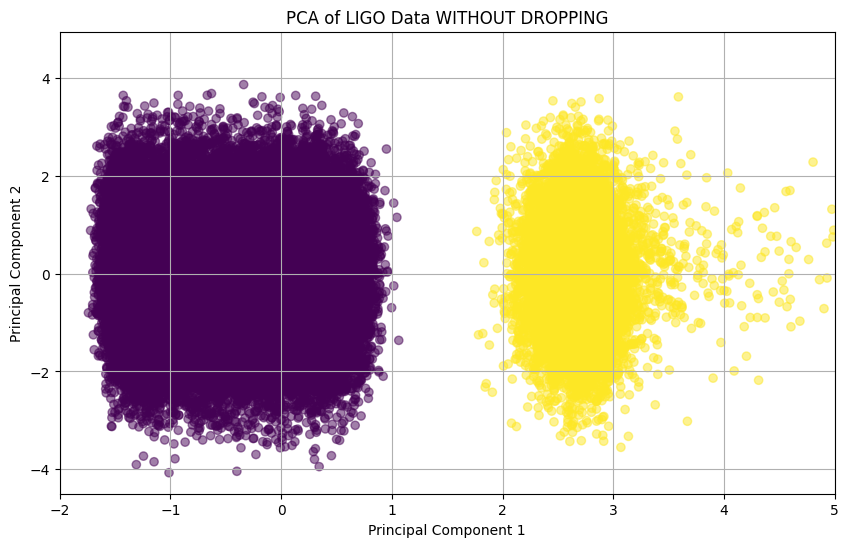

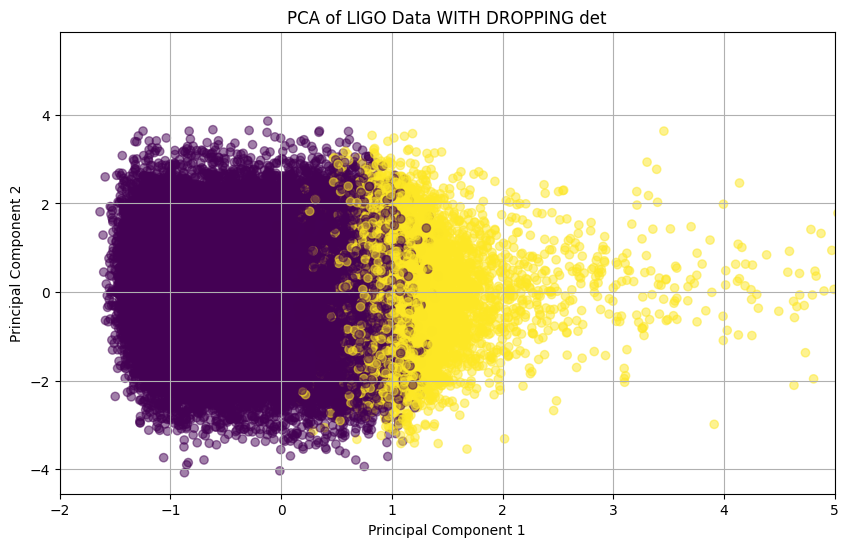

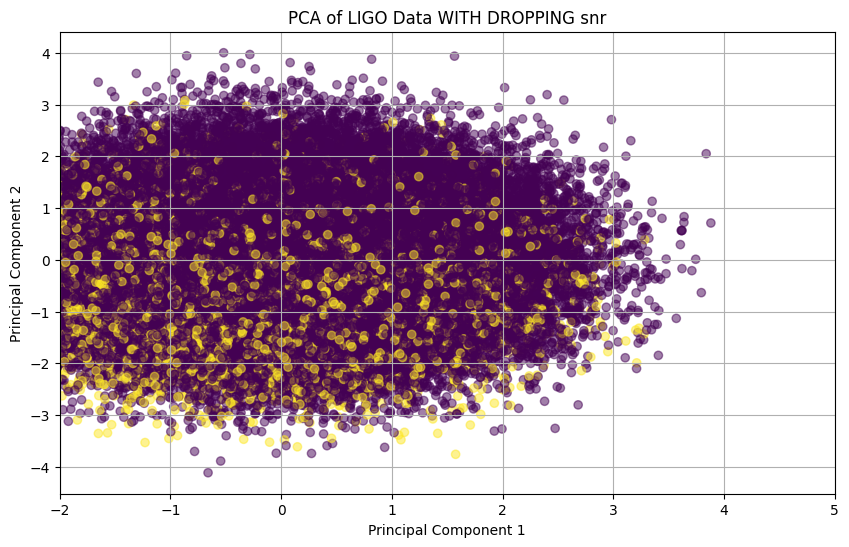

Explained variance by each component: [7.85273181 7.7973384  7.75780485 7.72691262 7.71830049]%


In [3]:

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

y = np.array(df['det'])
X_scaled = StandardScaler().fit_transform(df)

pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.5)
plt.title('PCA of LIGO Data WITHOUT DROPPING')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.xlim(-2, 5)
plt.show() 


df = df.drop(columns=['det'])  # drop the target variable from features, LEAVE SNR
X_scaled = StandardScaler().fit_transform(df)

pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.5)
plt.title('PCA of LIGO Data WITH DROPPING det')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.xlim(-2, 5)
plt.show() 

df = df.drop(columns=['snr'])  # drop the target variable from features, snr > 12 means detected, so using it as a feature would be cheating
X_scaled = StandardScaler().fit_transform(df)

pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.5)
plt.title('PCA of LIGO Data WITH DROPPING snr')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.xlim(-2, 5)
plt.show() 

# percentuage of explained variance
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by each component: {explained_variance*100}%")

# I know that the first two component explain to little of the variance, but I just want to see the distribution of the data


In [4]:
from sklearn.metrics import roc_curve, confusion_matrix  
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3) # 30% test size, 70% train size


# RANDOM FOREST CLASSIFIER

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 7, 10]
}

grid = GridSearchCV(RandomForestClassifier(criterion='entropy', n_jobs=-1),
                    param_grid,
                    cv=5,
                    scoring='accuracy')
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best cross-validated score:", grid.best_score_)


Best params: {'max_depth': 10, 'n_estimators': 200}
Best cross-validated score: 0.9606428571428571


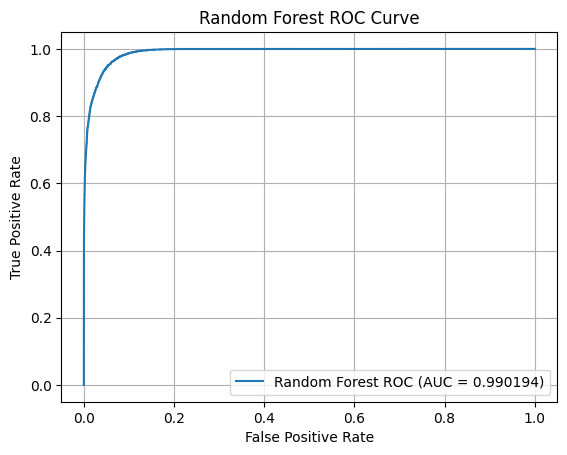

Completeness: 0.82, Contamination: 0.09
Confusion Matrix:
[[25287   368]
 [  763  3582]]


In [6]:
best_params = grid.best_params_

ranfor = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    criterion='entropy',
    n_jobs=-1
)
ranfor.fit(X_train, y_train)

y_score = ranfor.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = np.trapezoid(tpr, fpr)

plt.plot(fpr, tpr, label=f'Random Forest ROC (AUC = {roc_auc:.6f})')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

y_pred = ranfor.predict(X_test)
C = confusion_matrix(y_test, y_pred)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
completeness = tp / (tp + fn)
contamination = fp / (tp + fp)

print(f"Completeness: {completeness:.2f}, Contamination: {contamination:.2f}")
print("Confusion Matrix:")
print(C)

# ADABOOST

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier 

param_grid = {
    'n_estimators': [200, 250, 300], #it was taking too much ...
    'max_depth': [ 7, 8],
    'learning_rate': [0.01, 0.05]
}

base_model = GradientBoostingClassifier()

grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv = 5,  # 5-fold CV
    scoring='roc_auc',
    verbose=2,
    n_jobs=-1  # Use all cores
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=200; total time= 5.2min
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=200; total time= 5.3min
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=200; total time= 5.6min
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=200; total time= 5.6min
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=200; total time= 5.6min
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=250; total time= 6.9min
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=250; total time= 6.9min
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=250; total time= 7.2min
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=250; total time= 7.3min
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=250; total time= 7.3min
[CV] END ..learning_rate=0.01, max_depth=8, n_estimators=200; total time= 6.7min
[CV] END ..learning_rate=0.01, max_depth=7, n_es

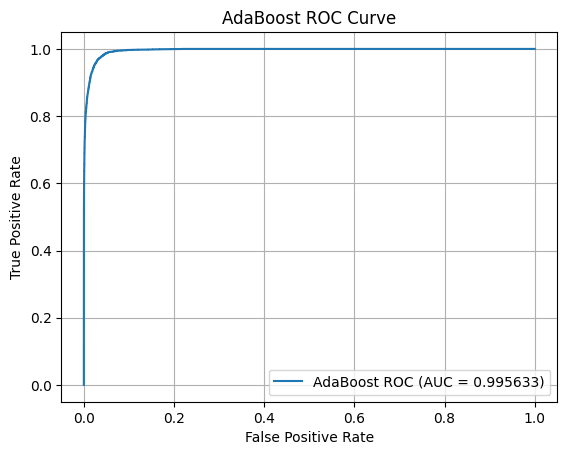

Completeness: 0.89, Contamination: 0.07
Confusion Matrix:
[[25353   302]
 [  467  3878]]


In [16]:
y_score = best_model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = np.trapezoid(tpr, fpr)

plt.plot(fpr, tpr, label=f'AdaBoost ROC (AUC = {roc_auc:.6f})')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AdaBoost ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

y_pred = best_model.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
completeness = tp / (tp + fn)
contamination = fp / (tp + fp)

print(f"Completeness: {completeness:.2f}, Contamination: {contamination:.2f}")

C = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(C)


# DECISION TREE CLASSIFIER

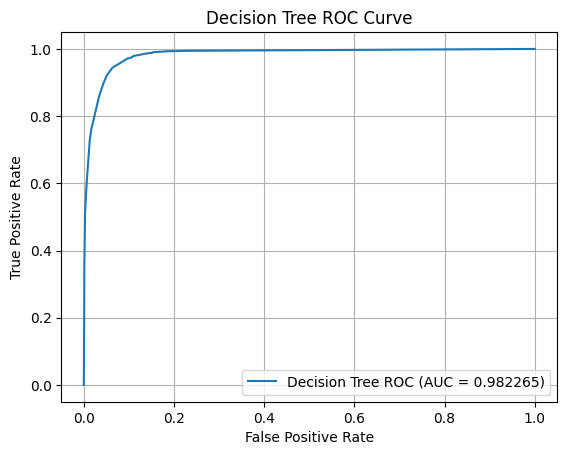

Completeness: 0.77, Contamination: 0.12
Confusion Matrix:
[[25232   446]
 [ 1015  3307]]


In [ ]:
#I know I know ... I should do a gridsearch over every one, but Im interested in see the best result, don't really have the time to make the best out of everyone

from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=1, max_depth=7,criterion='entropy')
clf.fit(X_train, y_train)

y_score = clf.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = np.trapezoid(tpr, fpr)

plt.plot(fpr, tpr, label=f'Decision Tree ROC (AUC = {roc_auc:.6f})')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Decision Tree ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

y_pred = clf.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
completeness = tp / (tp + fn)
contamination = fp / (tp + fp)

print(f"Completeness: {completeness:.2f}, Contamination: {contamination:.2f}")

C = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(C)


# LOGISTIC REGRESSION

/home/bossi_ricky/WSL_Shared/myenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


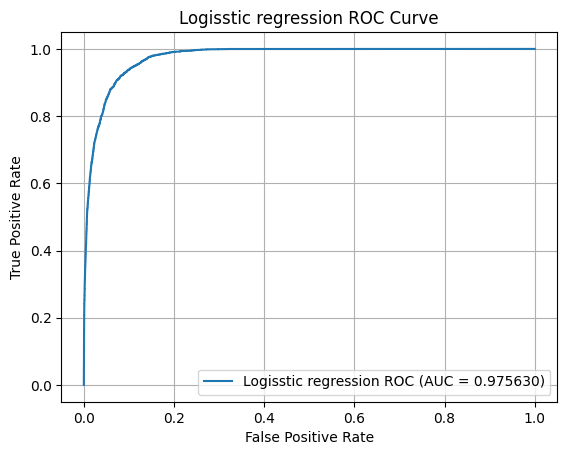

Completeness: 0.78, Contamination: 0.21
Confusion Matrix:
[[24783   895]
 [  963  3359]]


In [8]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

clf.fit(X_train, y_train)

y_score = clf.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = np.trapezoid(tpr, fpr)

plt.plot(fpr, tpr, label=f'Logisstic regression ROC (AUC = {roc_auc:.6f})')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logisstic regression ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

y_pred = clf.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
completeness = tp / (tp + fn)
contamination = fp / (tp + fp)

print(f"Completeness: {completeness:.2f}, Contamination: {contamination:.2f}")

C = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(C)

# SVM

/tmp/ipykernel_25515/1290498757.py:8: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc = np.trapz(tpr, fpr)


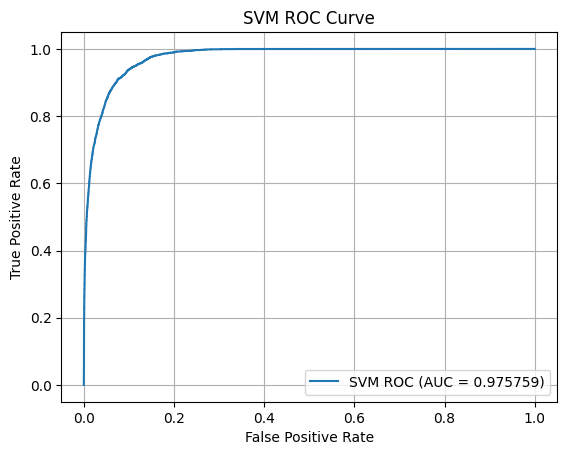

Completeness: 0.78, Contamination: 0.21
Confusion Matrix:
[[24803   875]
 [  949  3373]]


In [ ]:

#THIS TOOK 300 min

from sklearn.svm import SVC 
clf = SVC(kernel='linear', probability=True, random_state=42)

clf.fit(X_train, y_train)

y_score = clf.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = np.trapz(tpr, fpr)

plt.plot(fpr, tpr, label=f'SVM ROC (AUC = {roc_auc:.6f})')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("SVM ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

y_pred = clf.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
completeness = tp / (tp + fn)
contamination = fp / (tp + fp)

print(f"Completeness: {completeness:.2f}, Contamination: {contamination:.2f}")

C = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(C)


# BAGGING

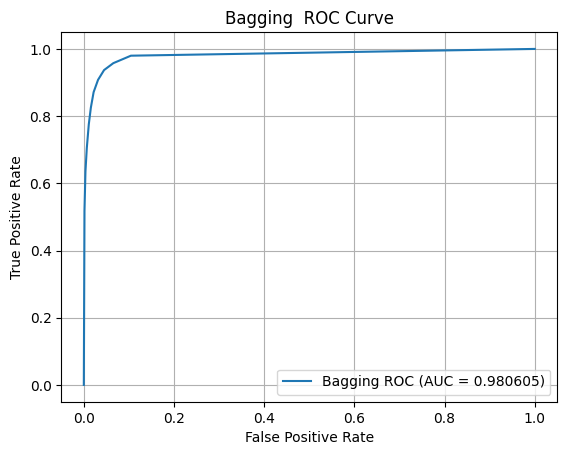

Completeness: 0.83, Contamination: 0.10
Confusion Matrix:
[[25278   400]
 [  756  3566]]


In [10]:
from sklearn.ensemble import BaggingClassifier
clf = BaggingClassifier()

clf.fit(X_train, y_train)

y_score = clf.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = np.trapezoid(tpr, fpr)

plt.plot(fpr, tpr, label=f'Bagging ROC (AUC = {roc_auc:.6f})')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Bagging  ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

y_pred = clf.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
completeness = tp / (tp + fn)
contamination = fp / (tp + fp)

print(f"Completeness: {completeness:.2f}, Contamination: {contamination:.2f}")

C = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(C)

# XGB classifier


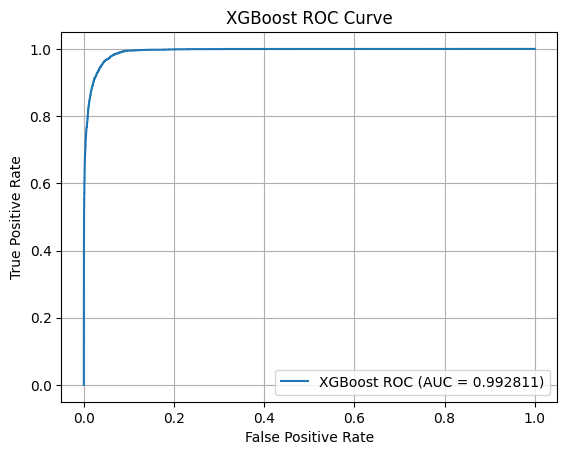

Completeness: 0.87, Contamination: 0.09
Confusion Matrix:
[[25263   392]
 [  579  3766]]


In [11]:
from xgboost import XGBClassifier

clf = XGBClassifier( n_estimators=100, max_depth=5, learning_rate=0.05, random_state=42)

clf.fit(X_train, y_train)

y_score = clf.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = np.trapezoid(tpr, fpr)

plt.plot(fpr, tpr, label=f'XGBoost ROC (AUC = {roc_auc:.6f})')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGBoost ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

y_pred = clf.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
completeness = tp / (tp + fn)
contamination = fp / (tp + fp)

print(f"Completeness: {completeness:.2f}, Contamination: {contamination:.2f}")

C = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(C)

# XGBoost Classifier 

**XGBoost** (Extreme Gradient Boosting) is a highly efficient and scalable implementation of gradient boosted decision trees. It's widely used in machine learning competitions and production settings due to its speed and performance.

The core idea is to **combine the predictions of many weak learners (typically decision trees)** to form a strong predictor. At each stage, it adds a new tree that focuses on the residual errors of the previous ensemble.

##  How does `XGBClassifier` work?
The `XGBClassifier` trains an ensemble of decision trees in a **boosted** manner:

1. Start with an initial model (e.g., predicting the average probability).
2. Compute residuals (how wrong the current model is).
3. Fit a new tree to the residuals.
4. Add this new tree to the model with a **learning rate** factor.
5. Repeat steps 2–4 for a number of iterations (n_estimators).

It uses **gradient descent** on the loss function (e.g., log loss) to minimize prediction error over multiple boosting rounds.


| Parameter                | Description                                                                 |
|--------------------------|-----------------------------------------------------------------------------|
| `n_estimators=300`       | Number of boosting rounds (i.e., trees). More trees → higher capacity.      |
| `max_depth=6`            | Maximum depth of each tree. Higher depth captures more patterns but may overfit. |
| `learning_rate=0.05`     | Shrinks the contribution of each tree. Low values need more trees.          |
| `subsample=0.8`          | Fraction of training data used per tree → prevents overfitting.             |
| `colsample_bytree=0.8`   | Fraction of features used per tree → adds randomness, reduces overfitting.  |
| `random_state=42`        | Seed for reproducibility.                                                   |
| `use_label_encoder=False`| Disables old label encoder (recommended for newer versions of XGBoost).     |
| `eval_metric='logloss'`  | Metric to evaluate model performance during training. 'logloss' for classification. |



##  When to Use XGBoost?

- High-dimensional datasets (lots of features).
- Tabular data (structured datasets).
- Problems with missing values.
- You care about model performance and speed.



Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   1.2s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   1.2s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   1.2s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=150; total time=   1.7s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=150; total time=   2.1s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=150; total time=   2.2s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   1.8s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   2.0s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=200; total time=   3.4s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=200; total time=   3.8s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=200; total time=   3.7s
[CV] END ..learning_rate=0.01, max_depth=5, n_e

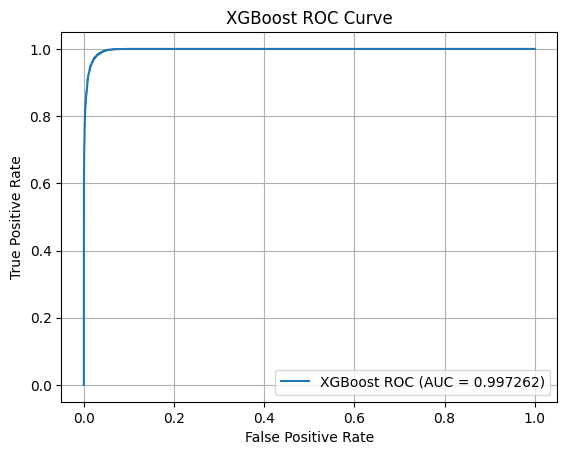

Completeness: 0.92, Contamination: 0.06
Confusion Matrix:
[[25412   243]
 [  354  3991]]


In [14]:
# I choose to fit this, because it's really fast and it's really good 

param_grid = {
    'n_estimators': [100, 150 ,200, 250, 300, 350],
    'max_depth': [ 5, 6, 7, 8, 9],
    'learning_rate': [0.01, 0.05, 0.1]
}

base_model = XGBClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv = 5,  # 5-fold CV
    scoring='roc_auc',
    verbose=2,
    n_jobs=-1  # Use all cores
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

y_score = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc =np.trapezoid( tpr, fpr)

plt.plot(fpr, tpr, label=f'XGBoost ROC (AUC = {roc_auc:.6f})')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGBoost ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

y_pred = best_model.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
completeness = tp / (tp + fn)
contamination = fp / (tp + fp)

print(f"Completeness: {completeness:.2f}, Contamination: {contamination:.2f}")

C = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(C)